Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [2]:
import numpy as np
import pandas as pd 
import scipy.sparse
%matplotlib inline

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [3]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368550 entries, 0 to 368549
Data columns (total 3 columns):
pairId      368550 non-null int64
FirstId     368550 non-null int64
SecondId    368550 non-null int64
dtypes: int64(3)
memory usage: 8.4 MB


In [33]:
# It seems like Ids are reused
print('How often the amounts of FirstIds are used are used')
print('i.e. 1755 times the same FirstId is reused 15 times')
print('-'*50)
print('Indices:', test.FirstId.value_counts().value_counts().index)
print('Unique values:', sum(test.FirstId.value_counts().value_counts()))
print('Unique values double-check:', test.FirstId.nunique())
print('Unique values triple-check:', 15*1755) # As 15 rows & each time 1755 values
test.FirstId.value_counts().value_counts()

How often the amounts of FirstIds are used are used
i.e. 1755 times the same FirstId is reused 15 times
--------------------------------------------------
Indices: Int64Index([15, 14, 13, 12, 11, 10, 9, 8, 7, 21, 20, 19, 18, 17, 16], dtype='int64')
Unique values: 26325
Unique values double-check: 26325
Unique values triple-check: 26325


15    1755
14    1755
13    1755
12    1755
11    1755
10    1755
9     1755
8     1755
7     1755
21    1755
20    1755
19    1755
18    1755
17    1755
16    1755
Name: FirstId, dtype: int64

In [34]:
print('How often the amounts of SecondIds are used are used')
print('i.e. 1755 times the same SecondId is reused 14 times')
print('i.e. There is only one SecondId which is reused 23 times')
print('-'*50)
print('Indices:', test.SecondId.value_counts().value_counts().index)
print('Unique values:', sum(test.SecondId.value_counts().value_counts()))
print('Unique values double-check:', test.SecondId.nunique())
test.SecondId.value_counts().value_counts()

How often the amounts of SecondIds are used are used
i.e. 1755 times the same SecondId is reused 14 times
i.e. There is only one SecondId which is reused 23 times
--------------------------------------------------
Indices: Int64Index([14, 13, 12, 11, 10,  9,  8, 15, 17, 18, 19, 16, 20, 21,  7, 22,  6,
             5,  4,  3,  2,  1, 23],
           dtype='int64')
Unique values: 26310
Unique values double-check: 26310


14    1755
13    1755
12    1755
11    1755
10    1755
9     1755
8     1754
15    1740
17    1740
18    1740
19    1740
16    1740
20    1739
21    1695
7     1605
22     150
6       60
5       16
4       15
3       15
2       15
1       15
23       1
Name: SecondId, dtype: int64

In [35]:
print('If we look closely, we see that we cann add them all up to 15 chunks of 1755:')
count_series = test.SecondId.value_counts().value_counts()
print(count_series[:6])
print('8 + 23:', count_series.iloc[6] + count_series.iloc[-1])
#print(count_series.sort_index())
for i in range(14, 18, 1):
    print((i+1), '+', (i-13), count_series.sort_index().iloc[i] +  count_series.sort_index().iloc[i-14])
print('20 + 5:', count_series.iloc[12] + count_series.iloc[17])    
print('21 + 6:', count_series.iloc[13] + count_series.iloc[16])    
print('7 + 22:', count_series.iloc[14] + count_series.iloc[15])
print('All we are left with is No 19, with 1740 values exactly the 15 missing from 26325 - 26310')

If we look closely, we see that we cann add them all up to 15 chunks of 1755:
14    1755
13    1755
12    1755
11    1755
10    1755
9     1755
Name: SecondId, dtype: int64
8 + 23: 1755
15 + 1 1755
16 + 2 1755
17 + 3 1755
18 + 4 1755
20 + 5: 1755
21 + 6: 1755
7 + 22: 1755
All we are left with is No 19, with 1740 values exactly the 15 missing from 26325 - 26310


In [36]:
print('Current hypothesis: \t Assumming that each Id can only have one possible partner, each Id does have a partner, \
we have about the same amount of unique values in FirstId & SecondId, Ids overlap between First & Second (?) \
-> there can be only one combination where each Id is being used')

Current hypothesis: 	 Assumming that each Id can only have one possible partner, each Id does have a partner, we have about the same amount of unique values in FirstId & SecondId, Ids overlap between First & Second (?) -> there can be only one combination where each Id is being used


In [37]:
# Are Ids reused in First & Second ?
concat = pd.concat([test['FirstId'], test['SecondId']])
print(len(concat))
print('If nunique is smaller than 26325 + 26310, Ids are reused:')
print('Unique values in concat:', concat.nunique())

737100
If nunique is smaller than 26325 + 26310, Ids are reused:
Unique values in concat: 26325


In [38]:
# Recap:
# We have 26,325 unique IDs, hence a maximum of 13,162 pairs. (In fact only 13155, as only 26310 unique IDs in Second)
# The IDs are duplicated at least 7x  and up to 21x in column FirstId & 
#                       at least 1x and up to 23x in column SecondId
# To pair each unique ID in each possible combination the organizers would have needed (26,325 * 26,324) / 2 rows
# (assuming that order does not matter) -> 346,489,650 ; Instead we only have 368,550 rows
# Hence IDs cannot 

# Hypothesis: I think when creating the dataset they started with Putting each Id & its correct partner for a total
# of 13155 rows & 26310 unique IDs. Then in an effort to randomize things:
# They divided those unique IDs into 15 chunks of 1754 (15 * 1754 = 26310)

# The chunks could be either: Pairs
# In that case we have 1754 / 2 = 877 pairs in each chunk (877 * 15 = 13155)
# Or each chunk was made up of: Random IDs
# In that case, they would have had to be very careful not to pair them with their real partners

# They then took those 15 chunks and duplicated them in FirstId between 7 & 21 times
# In case 1, they then took all IDs, removed the IDs which were in the chunk, and assigned them 'at random' to
# each of those bigger chunks - e.g. Say chunk 1 was repeated 7 times, hence a total of 7*1754 entries
# They then took the total of 26310 IDs - the 1754 IDs in that chunk and assigned them to those 7*1754 entires via 
# Second Id
# I'm saying 'at random', as they seemed to change their approach of assigning SecondIDs throughout the process
# First they used each SecondID for the same amount of times (1754) and then varied them uniformly e.g. to 1740 etc.

# At the end they added another completely random ID to each chunk (IDs without a partner) 
# - changing the setup to 15 chunks of 1755


# Find the unique combination to satisfy the constrain that each ID is only used once
# In order to solve the problem let's turn it into a sparse matrix


# Mistake in my assumption / understanding: An ID can be scored as 1 with multiple different IDs! 
# It's not about unique pairing of IDs

In [39]:
# Create a matrix of shape [n_unique, n_unique]
adjacency_matrix = np.zeros((26325, 26325))
print(adjacency_matrix.shape)

for idx, row in test.iterrows():
    adjacency_matrix[row.FirstId, row.SecondId] += 1
    
print(np.sum(adjacency_matrix))

(26325, 26325)
368550.0


In [40]:
scipy.sparse.csr_matrix((3, 4), dtype=np.int8).toarray()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int8)

In [41]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
scipy.sparse.csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

#csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
#where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k].

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]], dtype=int64)

In [42]:
print('There seem to be distinct groups in SecondId')
groups = {'1-5': '15,16', '10-14': '1755', '15-19': '1740'}
print(groups)

There seem to be distinct groups in SecondId
{'1-5': '15,16', '10-14': '1755', '15-19': '1740'}


How many rows with same first & SecondId:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 186443 to 327330
Data columns (total 3 columns):
pairId      6 non-null int64
FirstId     6 non-null int64
SecondId    6 non-null int64
dtypes: int64(3)
memory usage: 192.0 bytes
--------------------------------------------------
Any duplicate rows?
False    368550
dtype: int64
--------------------------------------------------
Unique PairIDs: 368550
--------------------------------------------------
pairId      10000
FirstId      8288
SecondId     8265
dtype: int64
--------------------------------------------------
Any inverse duplicate rows?
<class 'pandas.core.frame.DataFrame'>
Int64Index: 737100 entries, 0 to 368549
Data columns (total 3 columns):
pairId      737100 non-null int64
FirstId     737100 non-null int64
SecondId    737100 non-null int64
dtypes: int64(3)
memory usage: 22.5 MB
None
Any duplicates, but swapped order?: False    737094
True          6
dtype: int64
----------

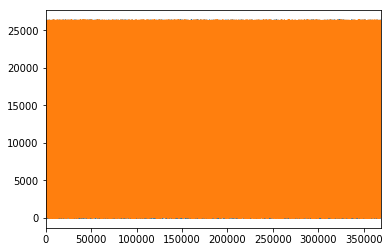

In [43]:
print('How many rows with same first & SecondId:')
test.loc[test.FirstId == test.SecondId].info()
print('-'*50)
print('Any duplicate rows?')
print(test.duplicated().value_counts())

# Any mistakes in pairId
print('-'*50)
print('Unique PairIDs:', test.pairId.nunique())

# Unique values in first 10000 rows
print('-'*50)
print(test[:10000].nunique())

print('-'*50)
print('Any inverse duplicate rows?')
id_inv_df = test[['pairId']].assign(FirstId = test.SecondId, SecondId = test.FirstId)
combined_df = pd.concat([test, id_inv_df])
print(combined_df.info())
print('Any duplicates, but swapped order?:', combined_df.duplicated().value_counts())

print('-'*50)
print('Distribution of Ids')
print(test.FirstId.min(), test.FirstId.max())
print(test.SecondId.min(), test.SecondId.max())
test.FirstId.plot.line()
test.SecondId.plot.line()

# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [4]:
# YOUR CODE GOES HERE
concat = pd.concat([test['FirstId'], test['SecondId']])
print('Unique values in concat:', concat.nunique())
print('Min & Max ID:', concat.min(), concat.max())

Unique values in concat: 26325
Min & Max ID: 0 26324


and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [5]:
# YOUR CODE GOES HERE
len(test)

368550

Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [6]:
# YOUR CODE GOES HERE
int((concat.nunique() * (concat.nunique() - 1) ) / 2)

346489650

So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [7]:
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [8]:
# YOUR CODE GOES HERE
prediction_df = test[['pairId']].assign(Prediction=1)
prediction_df.to_csv(index=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [9]:
# Drop duplicates
print(test.shape, test.shape[0]*2)
id_inv_df = test[['pairId']].assign(FirstId = test.SecondId, SecondId = test.FirstId)
combined_df = pd.concat([test, id_inv_df])
clean_test = combined_df.drop_duplicates(['FirstId','SecondId'])
print(clean_test.shape)

(368550, 3) 737100
(736872, 3)


In [10]:
# Rows:
i = np.array(clean_test['FirstId'])
# Cols:
j = np.array(clean_test['SecondId'])
print(i.shape, j.shape)
data = np.ones((736872))

inc_mat = scipy.sparse.coo_matrix((data, (i, j)))

# YOUR CODE GOES HERE (but probably you will need to write few more lines before)

# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

(736872,) (736872,)


It is convenient to have matrix in `csr` format eventually.

In [11]:
# Compressed Row Format
inc_mat = inc_mat.tocsr()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [14]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId = inc_mat[np.array(test.FirstId)]
# YOUR CODE GOES HERE
rows_SecondId = inc_mat[np.array(test.SecondId)]
# YOUR CODE GOES HERE
print(rows_FirstId.shape, rows_SecondId.shape)
print(rows_FirstId[0, :].sum())
print(rows_SecondId[0, :].sum())
print('The first ID in FirstId was repeated', np.sum(rows_FirstId[0, :]), ' times.')

print('The first ID is: ', test.FirstId[0])

print('-'*50)
print('Sanity Check:')
test.loc[test.FirstId == 1427].count() + test.loc[test.SecondId == 1427].count()


(368550, 26325) (368550, 26325)
36.0
36.0
The first ID in FirstId was repeated 36.0  times.
The first ID is:  1427
--------------------------------------------------
Sanity Check:


pairId      36
FirstId     36
SecondId    36
dtype: int64

Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [43]:
# Note, that in order to do pointwise multiplication in scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication

# Multiply the two IDs first, then take the sum  
# (It's like taking the dot product just instead of row * column, row*row & we only multiply each row with the first)
# We need to turn it back into an np array to be able to ravel it to the 1D shape
print(rows_FirstId.shape, rows_SecondId.shape)
f = np.array(np.sum(rows_FirstId.multiply(rows_SecondId), axis=1)).ravel()
print(f.shape)
print(f[:50])

# Sanity check
assert f.shape == (368550, )

(368550, 26325) (368550, 26325)
(368550,)
[ 20.  14.  20.  20.  14.  20.  14.  14.  14.  14.  20.  20.  20.  14.  14.
  14.  14.  14.  14.  20.  14.  20.  14.  20.  20.  14.  14.  14.  20.  20.
  20.  14.  14.  20.  14.  14.  14.  14.  20.  14.  14.  20.  20.  20.  14.
  14.  14.  20.  14.  14.]


That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [45]:
# For example use `np.unique` function, check for flags

print(np.unique(f, return_counts=True))
# -> Let's pick 18 as the threshold

# YOUR CODE GOES HERE

(array([ 14.,  15.,  19.,  20.,  21.,  28.,  35.]), array([183279,    852,    546, 183799,      6,     54,     14]))


Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [46]:
pred = f > 18 # SET THRESHOLD HERE

# Finally, let's create a submission

In [47]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission.csv', index=False)

In [48]:
# Feedback: Well done! Your accuracy score is 0.999609 

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!